In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=985c6608f2331107dd3cd6ce34854c4993fc80d449c899d973f6d01c5ee019e8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [69]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Start Spark session
spark = SparkSession.builder \
    .appName("Data Analysis and ML with PySpark") \
    .getOrCreate()

In [36]:
# Load data
df = spark.read.csv('Coimbra_breast_cancer_dataset.csv', header=True, inferSchema=True)

In [37]:
df.show()

+---+-----------+-------+-------+-----------+-------+-----------+--------+--------+--------------+
|Age|        BMI|Glucose|Insulin|       HOMA| Leptin|Adiponectin|Resistin|   MCP.1|Classification|
+---+-----------+-------+-------+-----------+-------+-----------+--------+--------+--------------+
| 48|       23.5|     70|  2.707|0.467408667| 8.8071|     9.7024| 7.99585| 417.114|             1|
| 83|20.69049454|     92|  3.115|0.706897333| 8.8438|   5.429285| 4.06405| 468.786|             1|
| 82|23.12467037|     91|  4.498|1.009651067|17.9393|   22.43204| 9.27715| 554.697|             1|
| 68|21.36752137|     77|  3.226|0.612724933| 9.8827|    7.16956|  12.766|  928.22|             1|
| 86|21.11111111|     92|  3.549|  0.8053864| 6.6994|    4.81924|10.57635|  773.92|             1|
| 49|22.85445769|     92|  3.226|0.732086933| 6.8317|   13.67975| 10.3176|  530.41|             1|
| 89|       22.7|     77|   4.69|0.890787333|  6.964|   5.589865| 12.9361|1256.083|             1|
| 76|     

In [38]:
# Rename problematic column
df = df.withColumnRenamed("MCP.1", "MCP_1")

In [39]:
# Data cleaning
df = df.dropDuplicates().dropna()

In [40]:
# Show duplicates
print("Duplicates:")
df.groupBy(df.columns).count().filter("count > 1").show()

Duplicates:
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+-----+
|Age|BMI|Glucose|Insulin|HOMA|Leptin|Adiponectin|Resistin|MCP_1|Classification|count|
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+-----+
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+-----+



In [41]:
from pyspark.sql.functions import col, sum
# Count null values for each column
print("Null values in each column:")
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

Null values in each column:
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+
|Age|BMI|Glucose|Insulin|HOMA|Leptin|Adiponectin|Resistin|MCP_1|Classification|
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+
|  0|  0|      0|      0|   0|     0|          0|       0|    0|             0|
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+



In [42]:
from functools import reduce
# Optional: Show rows with any null values
print("Rows with any null values:")
df.filter(
    reduce(lambda x, y: x | y, [col(c).isNull() for c in df.columns])
).show()

Rows with any null values:
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+
|Age|BMI|Glucose|Insulin|HOMA|Leptin|Adiponectin|Resistin|MCP_1|Classification|
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+
+---+---+-------+-------+----+------+-----------+--------+-----+--------------+



In [44]:
print("Descriptive statistics:")
df.describe().show()

Descriptive statistics:
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+
|summary|               Age|               BMI|           Glucose|          Insulin|              HOMA|           Leptin|       Adiponectin|          Resistin|            MCP_1|    Classification|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+
|  count|               116|               116|               116|              116|               116|              116|               116|               116|              116|               116|
|   mean| 57.30172413793103|27.582110827413807| 97.79310344827586|10.01208620689655|2.6949875643965506|26.61508017241378|10.180873965517241|14.725965862068962|534.6470000000002|1.551724137

In [45]:
# Correlations
for col_name in df.columns:
    if col_name != 'Classification':
        corr_value = df.stat.corr('Classification', col_name)
        print(f"Correlation between Classification and {col_name}: {corr_value}")

Correlation between Classification and Age: -0.04355468131279904
Correlation between Classification and BMI: -0.13258574047668434
Correlation between Classification and Glucose: 0.38431537674849653
Correlation between Classification and Insulin: 0.2768037140962369
Correlation between Classification and HOMA: 0.2840122224119574
Correlation between Classification and Leptin: -0.001078456594852531
Correlation between Classification and Adiponectin: -0.01949027968499623
Correlation between Classification and Resistin: 0.22731029564287705
Correlation between Classification and MCP_1: 0.09138051686160079


In [46]:
# Convert to Pandas DataFrame for visualization
pd_df = df.toPandas()

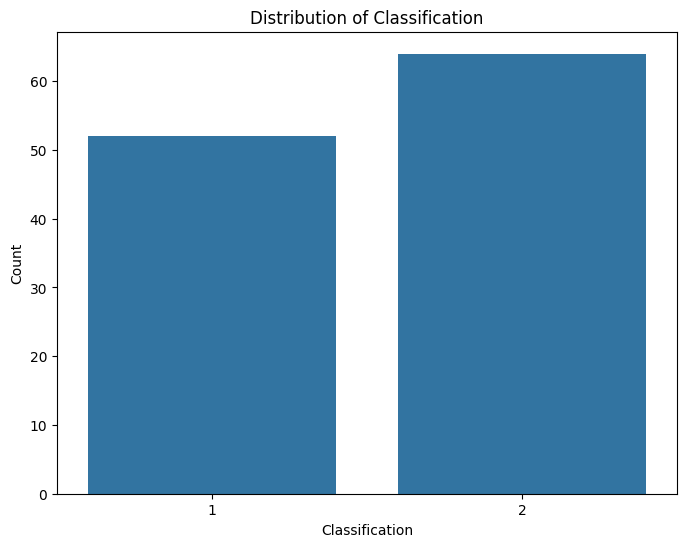

In [52]:
# Bar chart of target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Classification', data=pd_df)
plt.title('Distribution of Classification')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

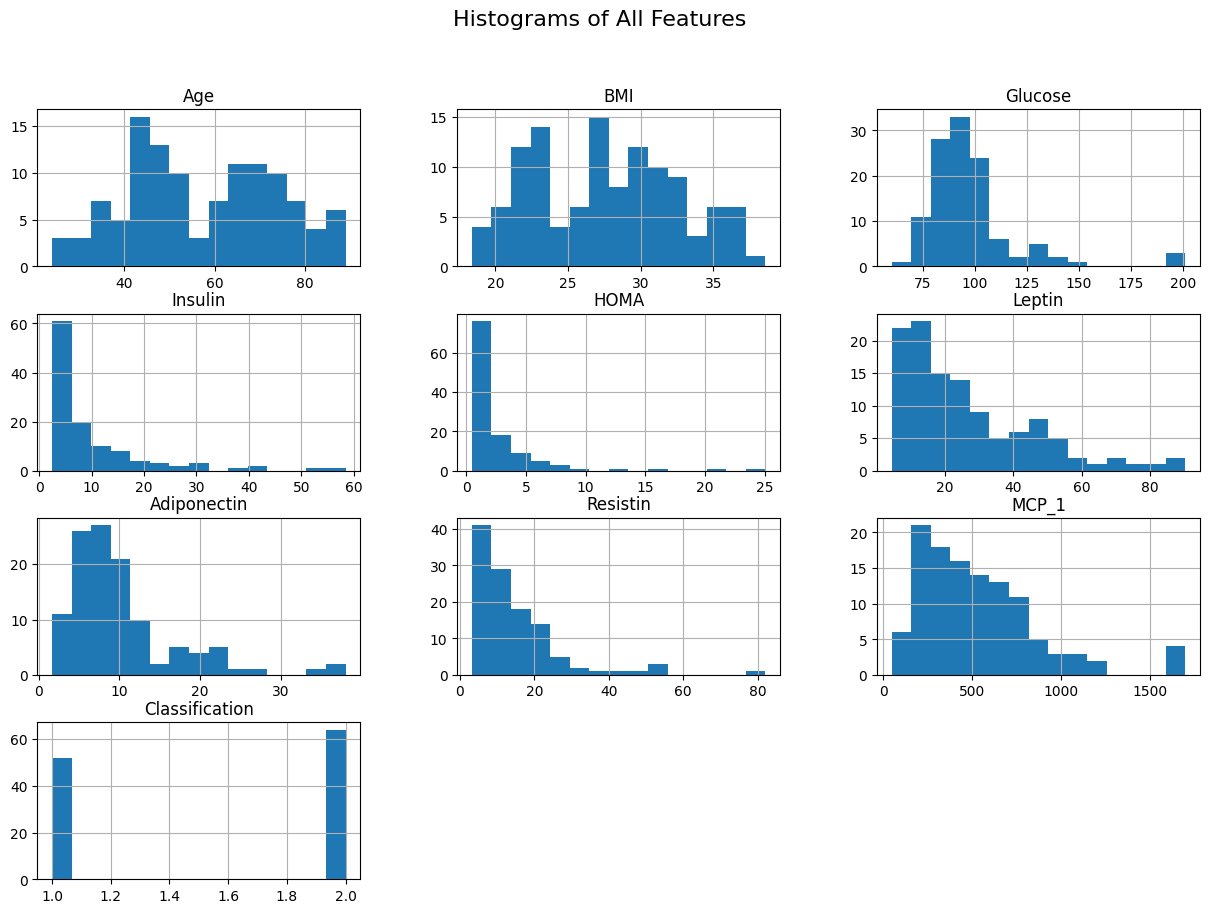

In [48]:
# Histograms
pd_df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograms of All Features', size=16)
plt.show()


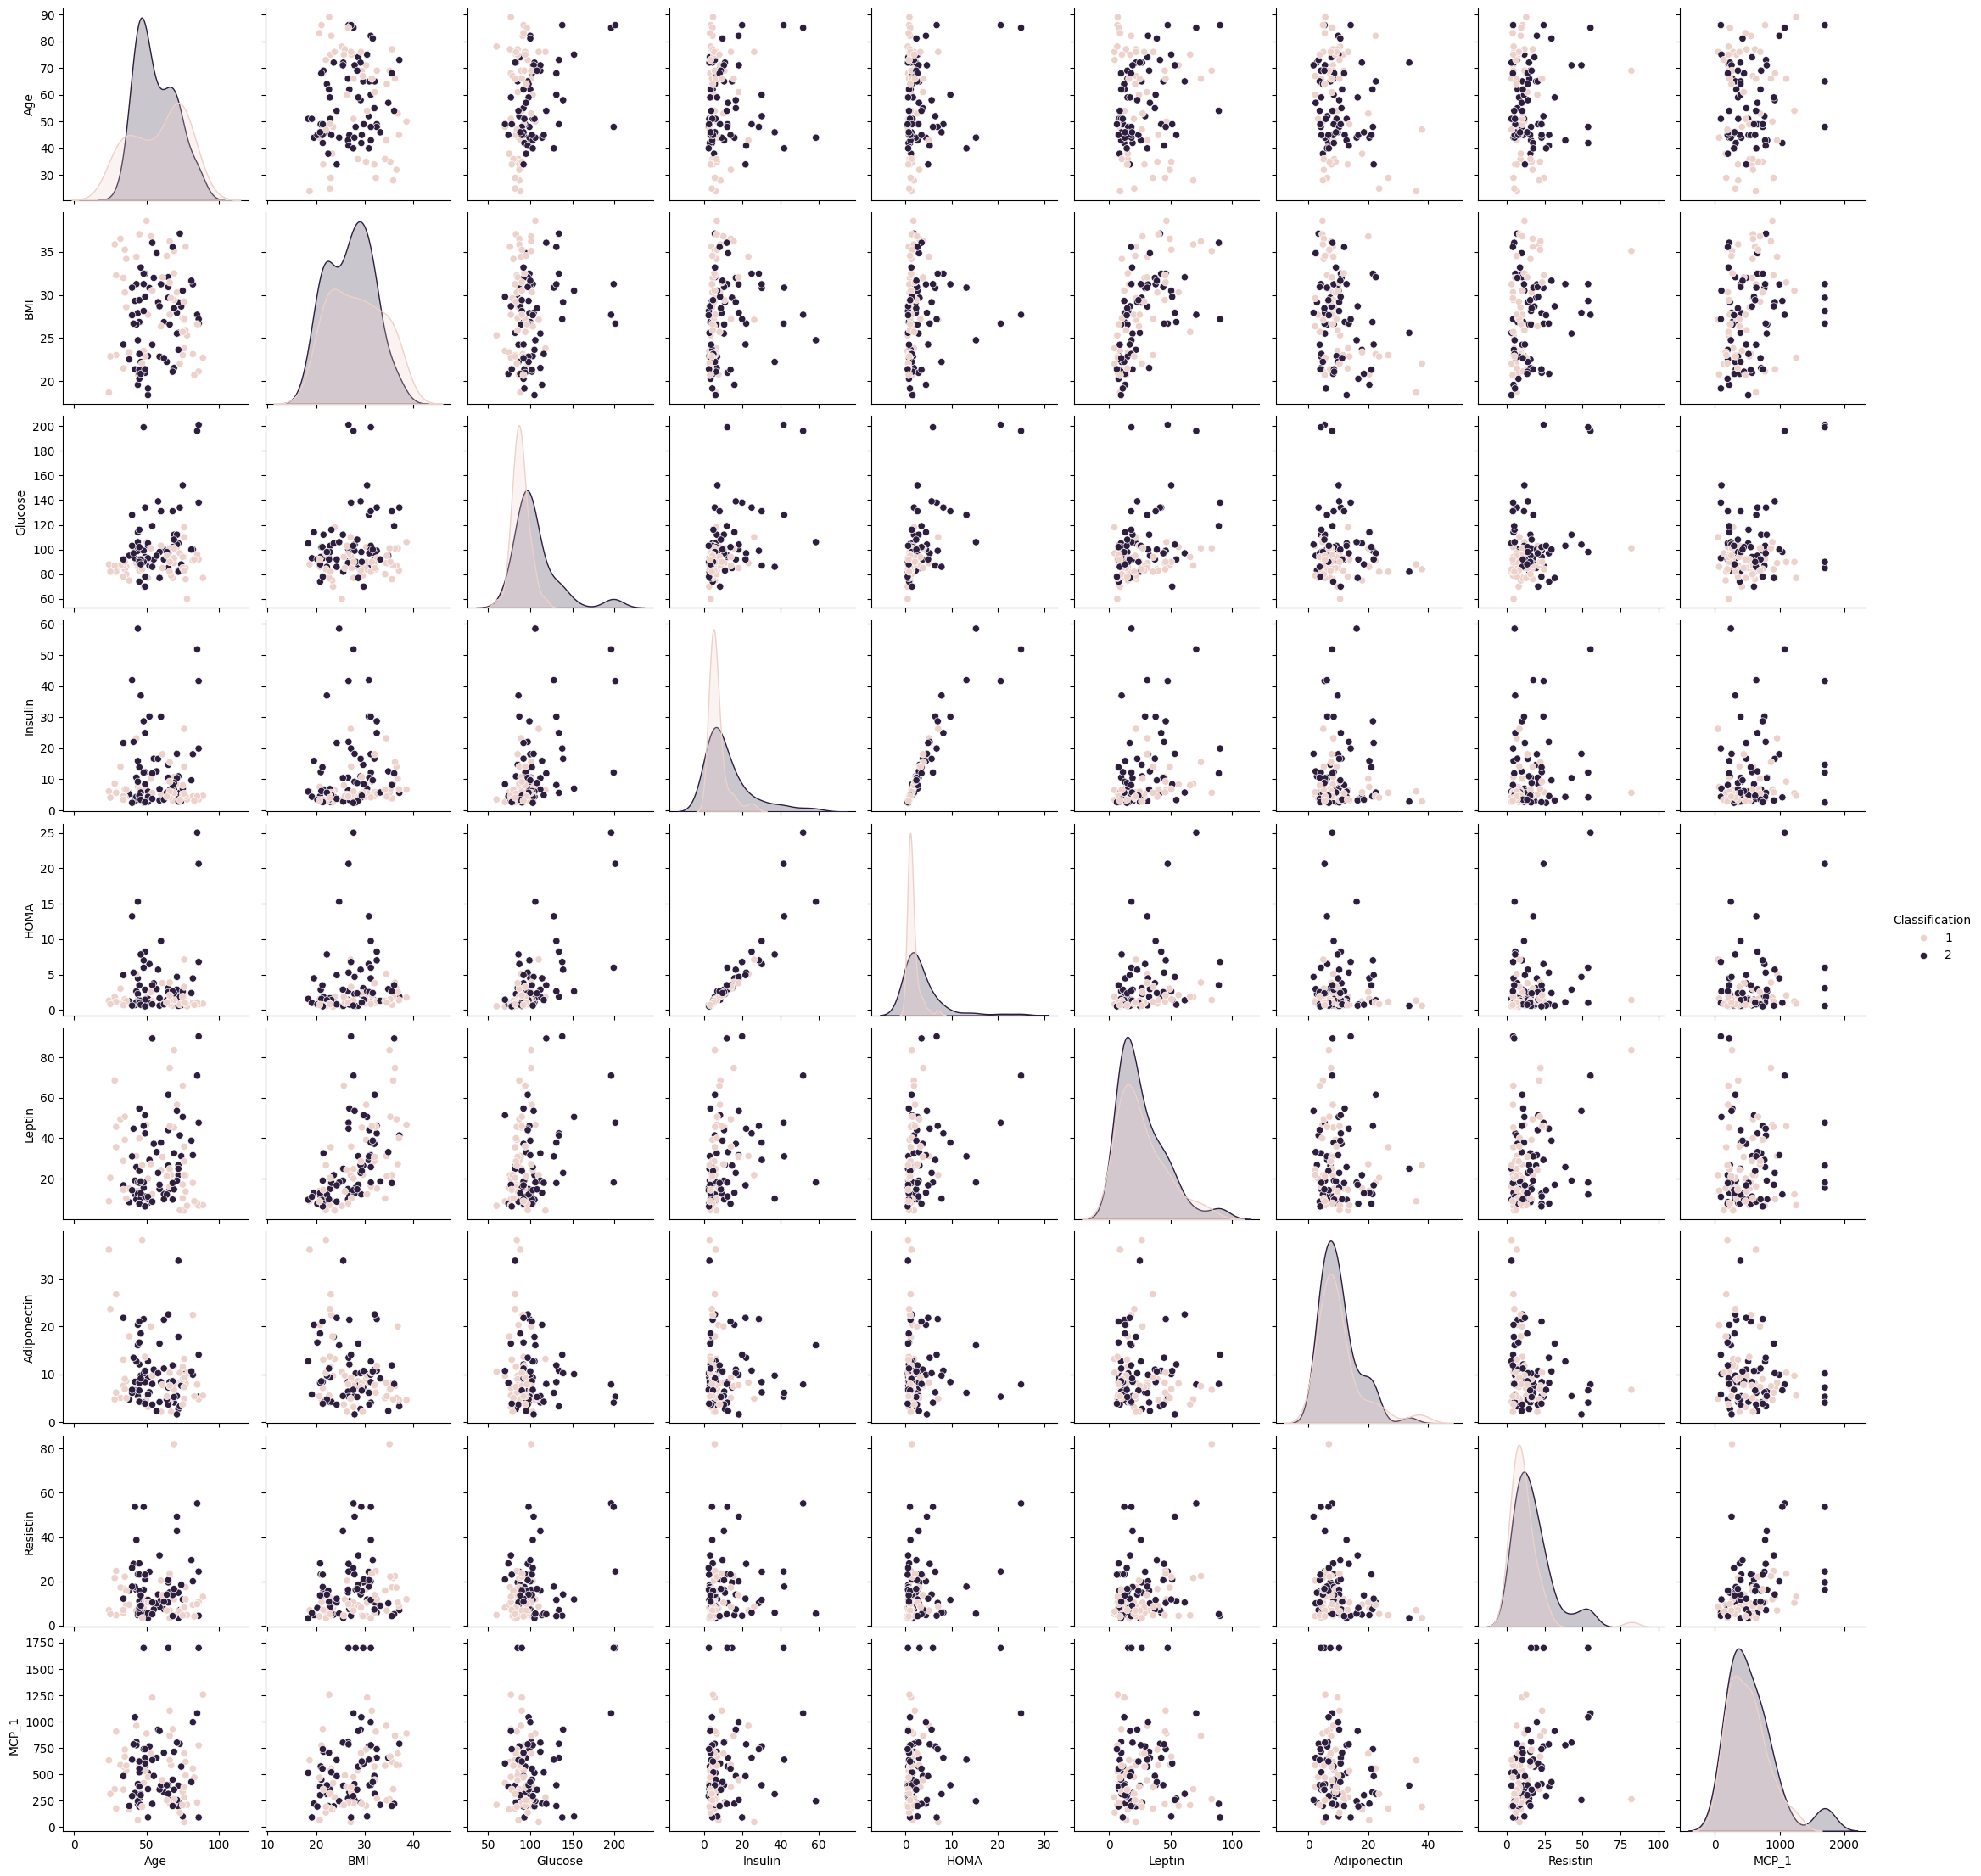

In [47]:
# Visualizations
# Pairplot
sns.pairplot(pd_df, hue='Classification')
plt.show()

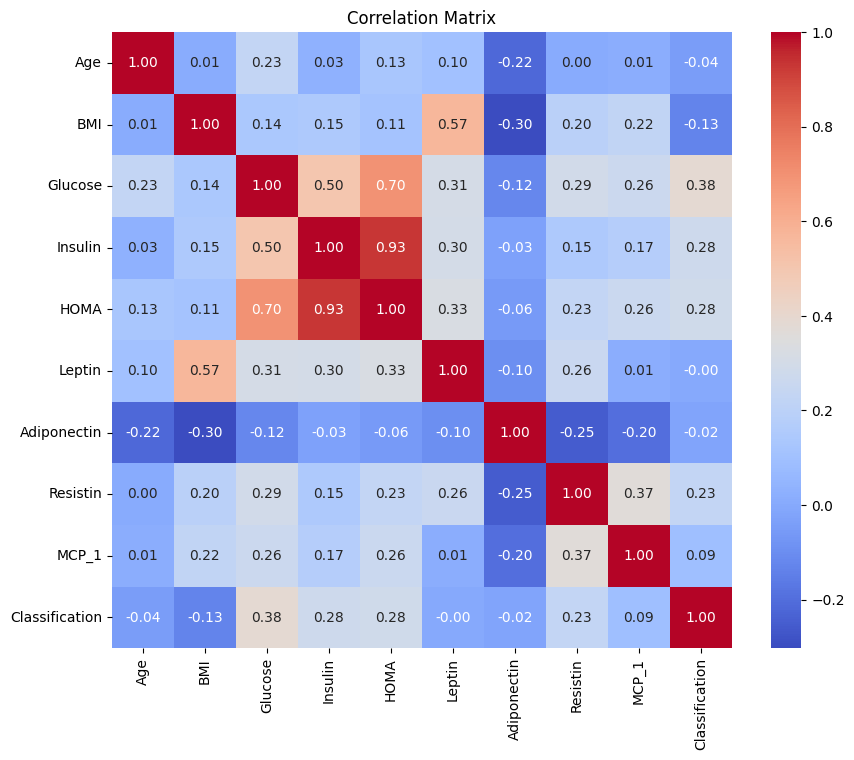

In [50]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
correlation_matrix = pd_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

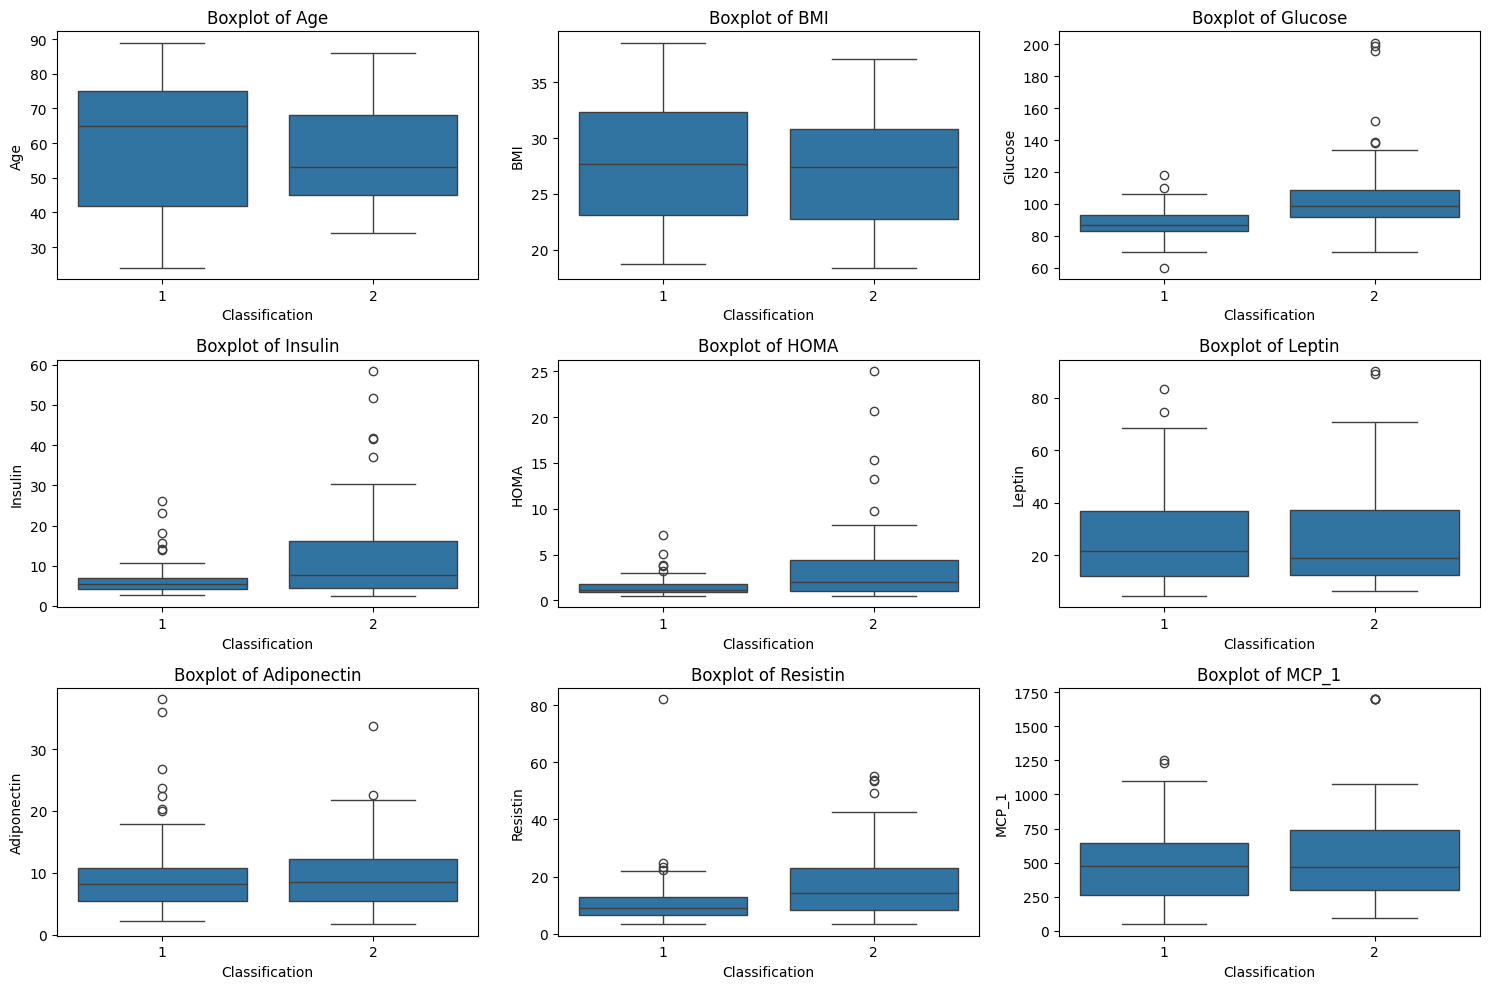

In [49]:
# Boxplots
plt.figure(figsize=(15, 10))
for i, col_name in enumerate(pd_df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Classification', y=col_name, data=pd_df)
    plt.title(f'Boxplot of {col_name}')
plt.tight_layout()
plt.show()

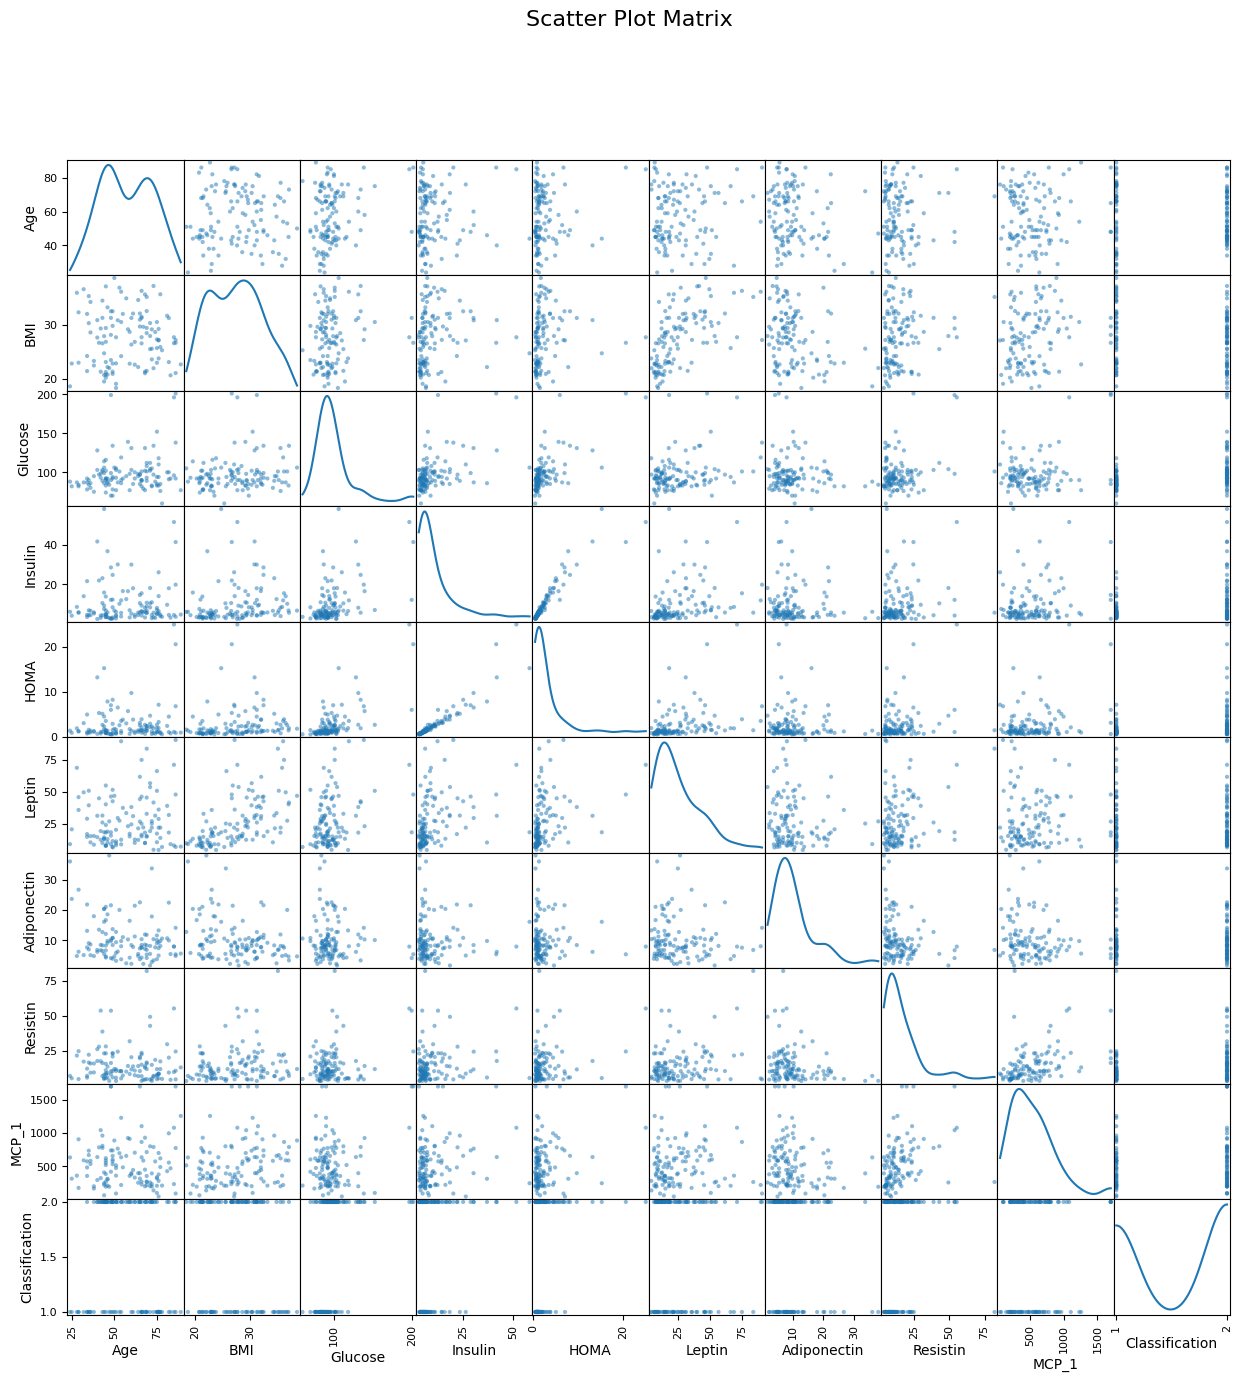

In [51]:
# Scatter plot matrix
pd.plotting.scatter_matrix(pd_df, figsize=(15, 15), diagonal='kde')
plt.suptitle('Scatter Plot Matrix', size=16)
plt.show()

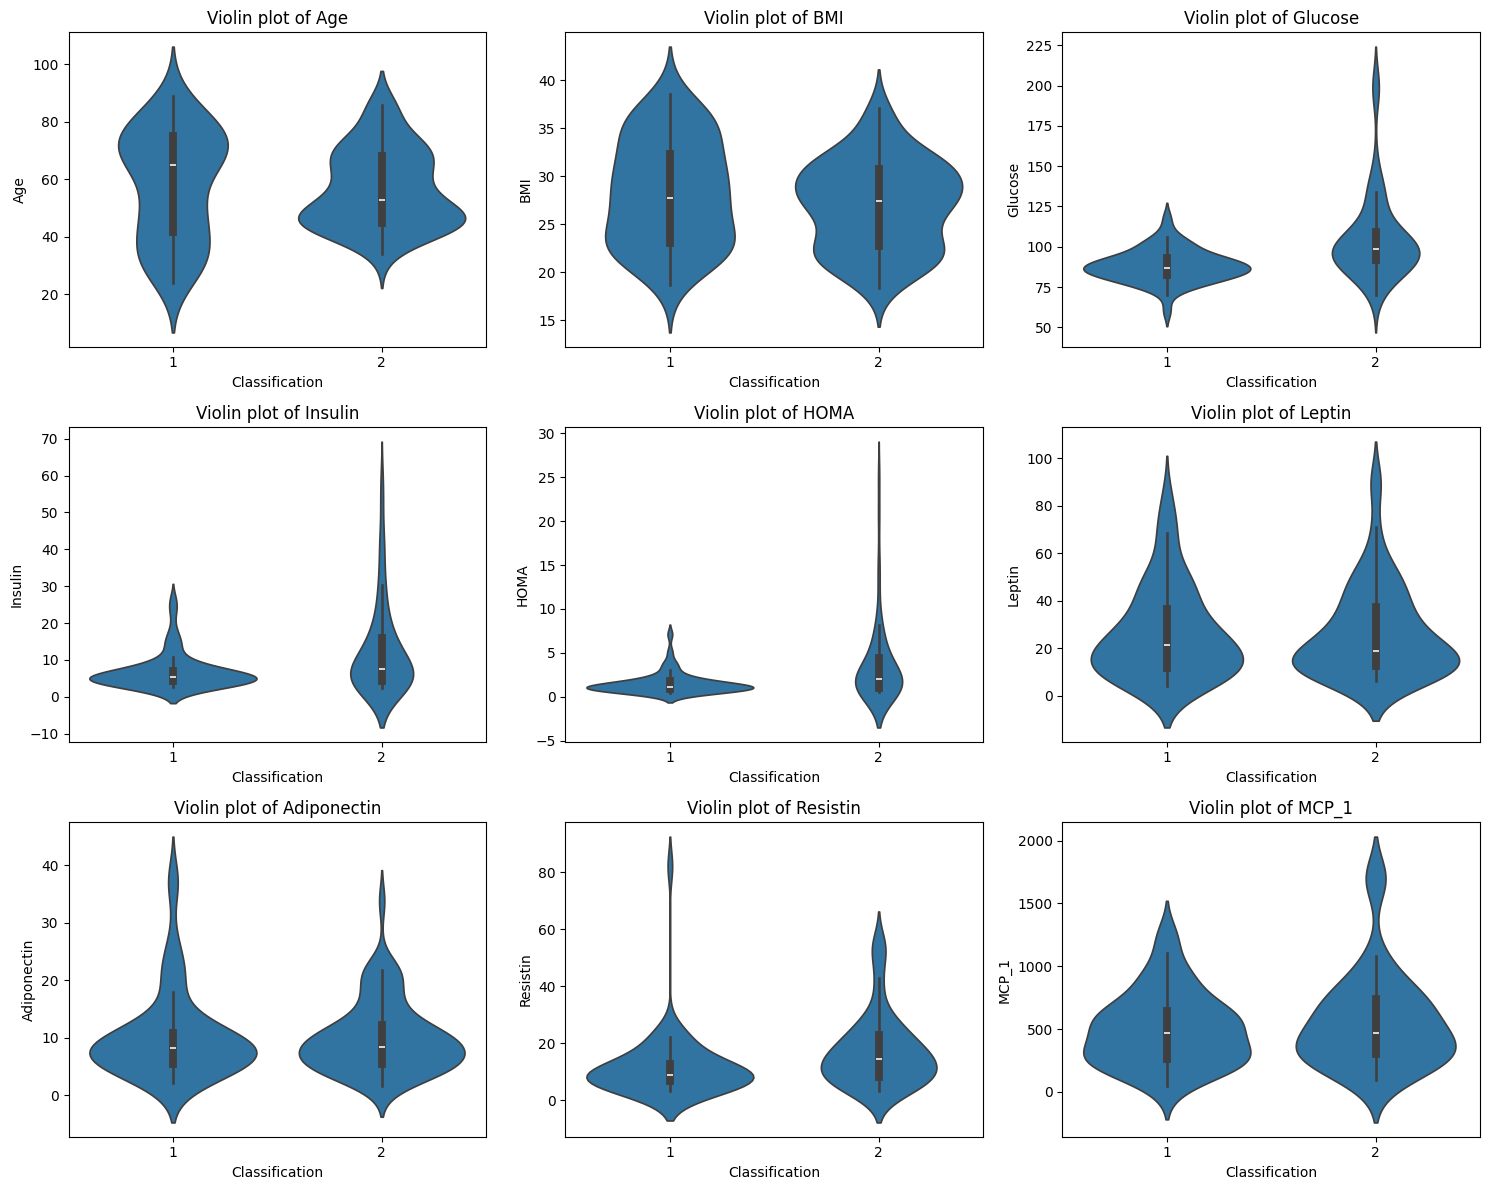

In [72]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(pd_df.columns[:-1]):  # Exclude the last column which is the 'Classification'
    plt.subplot(3, 3, i+1)
    sns.violinplot(x='Classification', y=column, data=pd_df)
    plt.title(f'Violin plot of {column}')
plt.tight_layout()
plt.show()

In [53]:
# Machine Learning Preparation
feature_columns = [col_name for col_name in df.columns if col_name != 'Classification']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df = assembler.transform(df)
df = df.select('features', 'Classification')

In [54]:
# Split data
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [55]:
# Train model
lr = LogisticRegression(labelCol='Classification', featuresCol='features')
lr_model = lr.fit(train_df)

In [56]:
# Make predictions
predictions = lr_model.transform(test_df)

In [57]:
# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol='Classification', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.6842105263157895


In [60]:
# Train Random Forest model
rf = RandomForestClassifier(labelCol='Classification', featuresCol='features')
rf_model = rf.fit(train_df)

In [61]:
# Make predictions
predictions = rf_model.transform(test_df)

In [62]:
# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol='Classification', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy (Random Forest): {accuracy}")

Test Accuracy (Random Forest): 0.6842105263157895
